In [1]:
import datetime as dt
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import Matern
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

C:\Users\oe739\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
start_time = pd.to_datetime("2008, 1, 1", infer_datetime_format=True, format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime("2013, 1, 1", infer_datetime_format=True, format='%Y-%m-%d %H:%M:%S')

In [4]:
df = web.DataReader('XOM', 'yahoo', start_time, end_time)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-01-02,94.550003,92.779999,94.150002,93.510002,23351900.0,62.734470
2008-01-03,94.739998,93.510002,93.860001,93.830002,19160600.0,62.949165
2008-01-04,94.360001,91.879997,93.239998,92.080002,24730900.0,61.775127
2008-01-07,93.150002,90.250000,92.500000,91.220001,28937500.0,61.198151
2008-01-08,92.050003,89.680000,91.860001,90.050003,21764500.0,60.413235


In [5]:
columns_=['High', 'Low', 'Open', 'Close']

df_noindex = df.reset_index(drop=True)

scaler_y = preprocessing.MinMaxScaler()
scaler_y.fit(df_noindex[columns_].values)
x_scaled = scaler_y.transform(df_noindex[columns_].values)
df_normalized = pd.DataFrame(x_scaled, columns=columns_)

In [6]:
high_training = df_normalized['High'].values
low_training = df_normalized['Low'].values
open_training = df_normalized['Open'].values
close_training = df_normalized['Close'].values

y_train = np.concatenate((
    high_training.reshape(-1, 1),
    low_training.reshape(-1, 1),
    open_training.reshape(-1, 1),
    close_training.reshape(-1, 1),
), axis=1)

scaler_x = preprocessing.MinMaxScaler()

scaler_x.fit(np.array(df_normalized.index).reshape(-1, 1))
x_train =  scaler_x.transform(np.array(df_normalized.index).reshape(-1, 1))

In [7]:
predict_from = 0
predict_to = 1450
x_predict = scaler_x.transform(np.arange(predict_from,predict_to,1).reshape(-1, 1))

In [8]:
kernel4 = 1**2 * RBF() + WhiteKernel(noise_level=0.01)
matern = 1**2* Matern(length_scale=1, nu=0.5)
gp = GaussianProcessRegressor(kernel=matern, copy_X_train =False, normalize_y=True, n_restarts_optimizer=5)

gp.fit(x_train, y_train)
print(gp)
    
y_predict, sigma = gp.predict(x_predict, return_std=True)

C:\Users\oe739\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:1444: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=False,
                         kernel=1**2 * Matern(length_scale=1, nu=0.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)


In [9]:
inversed = scaler_y.inverse_transform(y_predict)
df_predicted = pd.DataFrame(inversed, columns=columns_)
df_predicted.head()

,High,Low,Open,Close
0,94.550003,92.779999,94.150001,93.510002
1,94.739998,93.510002,93.860001,93.830002
2,94.360001,91.879997,93.239998,92.080002
3,93.150002,90.250000,92.500000,91.220001
4,92.050003,89.680000,91.860001,90.050003


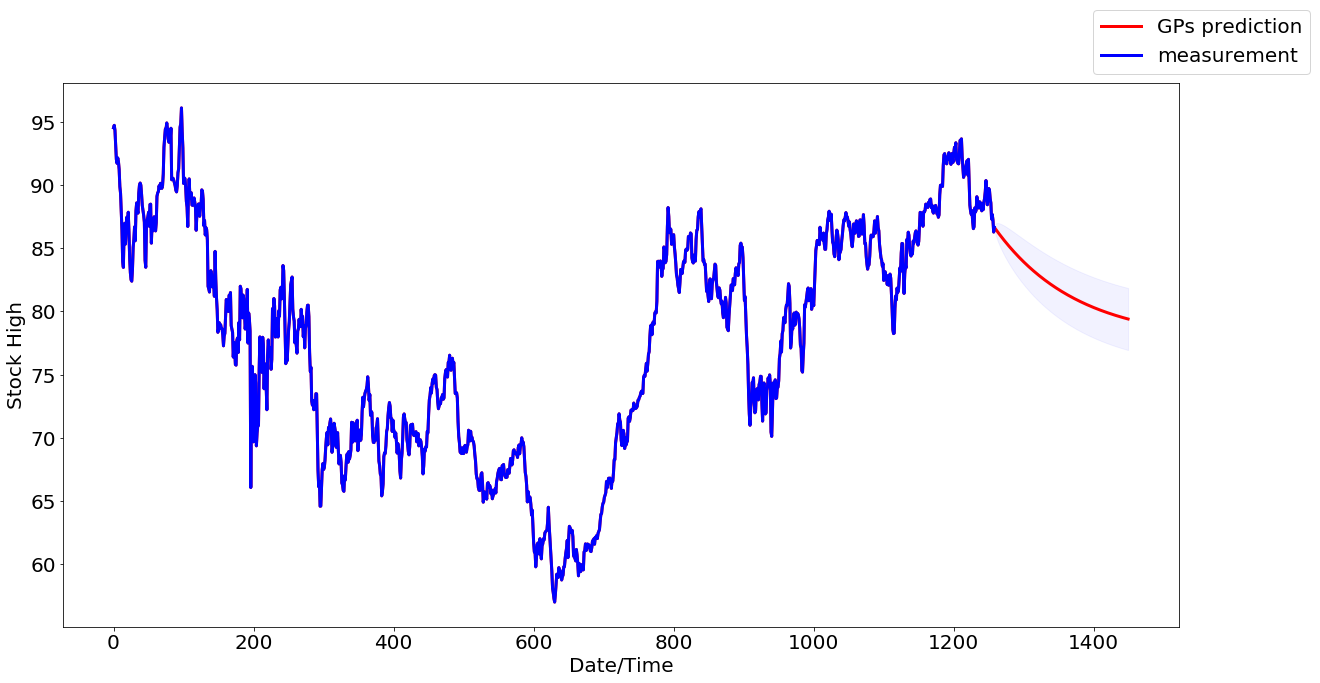

In [15]:
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


host, ax1 = plt.subplots(figsize = (20, 10))
ax1.set_xlabel("Index")
ax1.plot(df_predicted.index, df_predicted['High'].values, 'red', label = 'GPs prediction', linewidth = 3)
ax1.plot(df_noindex.index, df_noindex['High'].values, 'blue', label = 'measurement', linewidth = 3)
ax1.set_ylabel('Stock High', fontsize=20)
ax1.set_xlabel('Date/Time', fontsize=20)
    
ax1.fill_between(df_predicted.index, np.ravel(df_predicted['High'].values - 10*sigma)
             , np.ravel(df_predicted['High'].values + 10*sigma), alpha=0.05, color='b')
host.legend()